In [29]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("../")
from convex_adversarial_wong import DualNetBounds as DualNetBounds_LP, Affine, full_bias
from convex_adversarial import DualNetBounds as DualNetBounds

import gurobipy 
import cvxpy as cp
import time
%matplotlib inline
# import mpld3
# mpld3.enable_notebook()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Setup


In [30]:
epsilon = 1e-2
torch.manual_seed(1)
mnist_test = datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=1, shuffle=False, pin_memory=True)
for X,y in test_loader:
    break

sample = X.flatten()
num_classes = 10

#### Network random initialization

In [31]:
#### Network initialization
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

# net = nn.Sequential(
#     nn.Conv2d(1, 16, 4, stride=2, padding=1),
#     nn.ReLU(),
#     nn.Conv2d(16, 32, 4, stride=2, padding=1),
#     nn.ReLU(),
#     Flatten(),
#     nn.Linear(32*7*7,100),
#     nn.ReLU(),
#     nn.Linear(100, 10)
# )

# net = nn.Sequential(
#     nn.Conv2d(1, 32, 3, stride=1, padding=1),
#     nn.ReLU(),
#     nn.Conv2d(32, 32, 4, stride=2, padding=1),
#     nn.ReLU(),
#     nn.Conv2d(32, 64, 3, stride=1, padding=1),
#     nn.ReLU(),
#     nn.Conv2d(64, 64, 4, stride=2, padding=1),
#     nn.ReLU(),
#     Flatten(),
#     nn.Linear(64*7*7,512),
#     nn.ReLU(),
#     nn.Linear(512,512),
#     nn.ReLU(),
#     nn.Linear(512,10)
# )


net = nn.Sequential(
    Flatten(),
    nn.Linear(784,10),
    nn.ReLU(),
    nn.Linear(10,10),
    nn.ReLU(),
    nn.Linear(10,num_classes)
)

logits = net(X)
y_pred = logits.max(1)[1]
y_pred
# logits
# net

tensor([9])

## CMU algorithm

In [32]:
C = np.eye(num_classes)[y_pred] - np.eye(num_classes)

dual = DualNetBounds_LP(net, Variable(X), epsilon)

layers = dual.layers
affine = dual.affine
k = len(layers)

W = [l(Variable(torch.eye(l.in_features))).t().cpu().data.numpy() for l in affine]
b = [bias.view(-1).cpu().data.numpy() for bias in dual.biases]

margins_cmu = []
for ind_sample, sample in enumerate([sample]):
    sample = sample.reshape(-1)
    zl = [l.data[ind_sample,:].cpu().numpy() for l in dual.zl]
    zu = [u.data[ind_sample,:].cpu().numpy() for u in dual.zu]

    z = [cp.Variable(l.in_features) for l in affine]
    zhat = [cp.Variable(l.out_features) for l in affine]

    cons_eq = [zhat[i] == W[i]*z[i] + b[i] for i in range(k)]
    cons_ball = [z[0] >= sample - epsilon, z[0] <= sample + epsilon]
    cons_zero = [z[i] >= 0 for i in range(1,k)]
    cons_linear = [z[i+1] >= zhat[i] for i in range(k-1)]
    cons_upper = [(cp.multiply(-(np.maximum(zu[i],0) - np.maximum(zl[i], 0)), zhat[i]) +
                   cp.multiply((zu[i] - zl[i]), z[i+1]) <= 
                   zu[i]*np.maximum(zl[i],0) - zl[i]*np.maximum(zu[i],0)) for i in range(k-1)]

    cons = cons_eq + cons_ball + cons_zero + cons_linear + cons_upper
    
    # Exact
    for node_idx in range(zu[-1].shape[0]):
        f_primal = cp.Problem(cp.Minimize(C[node_idx]*zhat[-1]), cons).solve(verbose=False, solver=cp.GUROBI, warm_start=True)
        margins_cmu.append(f_primal)
    # print('Primal exact solution: \n',f_primal_1,'\n',f_primal_2)
    # print('Dual approximate solution: \n',f_dual_1.item(),'\n',f_dual_2.item())


ROBUST for epsilon=0.01!


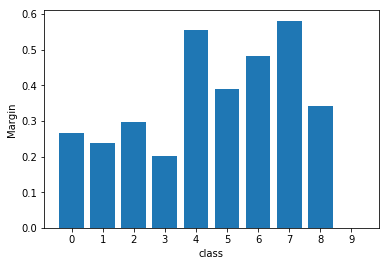

In [33]:
# print(margins_cmu)
plt.bar([i for i in range(10)],margins_cmu)
plt.ylabel('Margin')
plt.xlabel('class')
plt.xticks([i for i in range(10)])
if np.all(np.array(margins_cmu)>=0):
    print('ROBUST for epsilon={}!'.format(epsilon))
else:
    print('NOT ROBUST for epsilon={} :('.format(epsilon))

# Exact LP solution

In [34]:
def init_affine(net, X):
    layers = [l for l in net if isinstance(l, (nn.Linear, nn.Conv2d))]
    affine = [Affine(l) for l in layers]
    biases = [full_bias(l, affine[i].out_features) 
                    for i,l in enumerate(layers)]

    _ = X.view(1,-1)
    for a in affine: 
        _ = a(_)

    return affine, biases


In [35]:
C = np.eye(num_classes)[y_pred] - np.eye(num_classes)

affine, biases = init_affine(net, X)
num_linear_layers = len(affine)

W = [l(Variable(torch.eye(l.in_features))).t().cpu().data.numpy() for l in affine]
b = [bias.view(-1).cpu().data.numpy() for bias in biases]

points_all_samples = []
zl = [[] for i in range(num_linear_layers)]
zu = [[] for i in range(num_linear_layers)]
margins = []
end_time = time.time()
for k in range(num_linear_layers):
    print('Layer: ',k)
    print('Number of nodes in the layer: ',affine[k].out_features)
    z = [cp.Variable(l.in_features) for l in affine[:k+1]]
    zhat = [cp.Variable(l.out_features) for l in affine[:k+1]]

    cons_eq = [zhat[i] == W[i]*z[i] + b[i] for i in range(k+1)]
    cons_ball = [z[0] >= sample - epsilon, z[0] <= sample + epsilon]
    cons_zero = [z[i] >= 0 for i in range(1,k+1)]
    cons_linear = [z[i+1] >= zhat[i] for i in range(k)]
    cons_upper = [(cp.multiply(-(np.maximum(zu[i],0) - np.maximum(zl[i], 0)), zhat[i]) +
                    cp.multiply((zu[i] - zl[i]), z[i+1]) <= 
                    zu[i]*np.maximum(zl[i],0) - zl[i]*np.maximum(zu[i],0)) for i in range(k)]
    cons = cons_eq + cons_ball + cons_zero + cons_linear + cons_upper

    for node_idx in range(affine[k].out_features):
        if k == num_linear_layers-1:
            if node_idx == y_pred.item():
                margins.append(0)
                continue
            f_primal_1 = cp.Problem(cp.Minimize(C[node_idx]*zhat[-1]), cons).solve(verbose=False, solver=cp.ECOS, warm_start=True)
            margins.append(f_primal_1)
        else:
            # Exact
            f_primal_1 = cp.Problem(cp.Minimize(zhat[-1][node_idx]), cons).solve(verbose=False, solver=cp.ECOS, warm_start=True)
            f_min = zhat[-1][node_idx].value
            zl[k].append(f_min)

            f_primal_2 = cp.Problem(cp.Maximize(zhat[-1][node_idx]), cons).solve(verbose=False, solver=cp.ECOS, warm_start=True)
            f_max = zhat[-1][node_idx].value
            zu[k].append(f_max)
    zl[k] = np.array(zl[k])
    zu[k] = np.array(zu[k])
    iter_time = time.time()
    print("Time for solving this layer: {0} sec".format(iter_time-end_time))
    end_time = iter_time
    print('\n')

Layer:  0
Number of nodes in the layer:  10
Time for solving this layer: 0.23299956321716309 sec


Layer:  1
Number of nodes in the layer:  10
Time for solving this layer: 0.4010343551635742 sec


Layer:  2
Number of nodes in the layer:  10
Time for solving this layer: 0.24100422859191895 sec




ROBUST for epsilon=0.01!


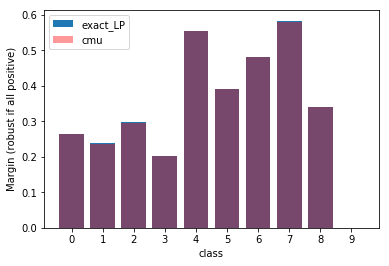

In [36]:
# np.array(margins) >= np.array(margins_cmu)
plt.bar([i for i in range(10)], margins, label='exact_LP')
plt.bar([i for i in range(10)], margins_cmu, color='r', alpha=0.4, label='cmu')
plt.legend()
plt.ylabel('Margin (robust if all positive)')
plt.xlabel('class')
plt.xticks([i for i in range(10)])
if np.all(np.array(margins)>=0):
    print('ROBUST for epsilon={}!'.format(epsilon))
else:
    print('NOT ROBUST for epsilon={} :('.format(epsilon))       

# Slightly faster version: decomposed constraints

In [37]:
C = np.eye(num_classes)[y_pred] - np.eye(num_classes)

affine, biases = init_affine(net, X)
num_linear_layers = len(affine)

W = [l(Variable(torch.eye(l.in_features))).t().cpu().data.numpy() for l in affine]
b = [bias.view(-1).cpu().data.numpy() for bias in biases]

zl = [[] for i in range(num_linear_layers)]
zu = [[] for i in range(num_linear_layers)]
margins = []

end_time = time.time()
for k in range(num_linear_layers):
    print('Layer: ',k)
    print('Number of nodes in the layer: ',affine[k].out_features)
    if k == num_linear_layers -1:
        z = [cp.Variable(l.in_features) for l in affine[:k+1]]
        zhat = [cp.Variable(l.out_features) for l in affine[:k+1]]

        cons_eq = [zhat[i] == W[i]*z[i] + b[i] for i in range(k+1)]
        cons_ball = [z[0] >= sample - epsilon, z[0] <= sample + epsilon]
        cons_zero = [z[i] >= 0 for i in range(1,k+1)]
        cons_linear = [z[i+1] >= zhat[i] for i in range(k)]
        cons_upper = [(cp.multiply(-(np.maximum(zu[i],0) - np.maximum(zl[i], 0)), zhat[i]) +
                        cp.multiply((zu[i] - zl[i]), z[i+1]) <= 
                        zu[i]*np.maximum(zl[i],0) - zl[i]*np.maximum(zu[i],0)) for i in range(k)]
        cons = cons_eq + cons_ball + cons_zero + cons_linear + cons_upper

        for node_idx in range(affine[k].out_features):
            if node_idx == y_pred.item():
                margins.append(0)
                continue
            f_primal_1 = cp.Problem(cp.Minimize(C[node_idx]*zhat[-1]), cons).solve(verbose=False, solver=cp.ECOS, warm_start=True)
            margins.append(f_primal_1)
        iter_time = time.time()
        print("Time for solving this layer: {0} sec".format(iter_time-end_time))
        end_time = iter_time
        print('\n')

        break    

    z = [cp.Variable(l.in_features) for l in affine[:k+1]]
    zhat = [cp.Variable(l.out_features) for l in affine[:k]]
    zhat += [cp.Variable(1)]
    cons_ball = [z[0] >= sample - epsilon, z[0] <= sample + epsilon]
    cons_zero = [z[i] >= 0 for i in range(1,k+1)]
    cons_linear = [z[i+1] >= zhat[i] for i in range(k)]
    cons_upper = [(cp.multiply(-(np.maximum(zu[i],0) - np.maximum(zl[i], 0)), zhat[i]) +
                cp.multiply((zu[i] - zl[i]), z[i+1]) <= 
                zu[i]*np.maximum(zl[i],0) - zl[i]*np.maximum(zu[i],0)) for i in range(k)]
    
    for node_idx in range(affine[k].out_features):
        cons_eq = [zhat[i] == W[i]*z[i] + b[i] for i in range(k)]
        cons_eq += [zhat[k] == W[k][node_idx]*z[k] + b[k][node_idx]]

        cons = cons_eq + cons_ball + cons_zero + cons_linear + cons_upper

        if k == num_linear_layers-1:
            if node_idx == y_pred.item():
                margins.append(0)
                continue
            f_primal_1 = cp.Problem(cp.Minimize(C[node_idx]*zhat[-1]), cons).solve(verbose=False, solver=cp.ECOS, warm_start=True)
            margins.append(f_primal_1)
        else:
            # Exact
            f_primal_1 = cp.Problem(cp.Minimize(zhat[-1]), cons).solve(verbose=False, solver=cp.ECOS, warm_start=True)
            f_min = zhat[-1][0].value
            zl[k].append(f_min)

            f_primal_2 = cp.Problem(cp.Maximize(zhat[-1]), cons).solve(verbose=False, solver=cp.ECOS, warm_start=True)
            f_max = zhat[-1][0].value
            zu[k].append(f_max)

    zl[k] = np.array(zl[k])
    zu[k] = np.array(zu[k])
    iter_time = time.time()
    print("Time for solving this layer: {0} sec".format(iter_time-end_time))
    end_time = iter_time
    print('\n')


Layer:  0
Number of nodes in the layer:  10
Time for solving this layer: 0.18199515342712402 sec


Layer:  1
Number of nodes in the layer:  10
Time for solving this layer: 0.39203691482543945 sec


Layer:  2
Number of nodes in the layer:  10
Time for solving this layer: 0.24196553230285645 sec




ROBUST for epsilon=0.01!


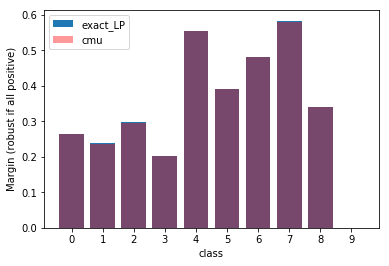

In [38]:
# np.array(margins) >= np.array(margins_cmu)
plt.bar([i for i in range(10)], margins, label='exact_LP')
plt.bar([i for i in range(10)], margins_cmu, color='r', alpha=0.4, label='cmu')
plt.legend()
plt.ylabel('Margin (robust if all positive)')
plt.xlabel('class')
plt.xticks([i for i in range(10)])
if np.all(np.array(margins)>=0):
    print('ROBUST for epsilon={}!'.format(epsilon))
else:
    print('NOT ROBUST for epsilon={} :('.format(epsilon))    

## Relu stability constraint elimination

In [39]:
C = np.eye(num_classes)[y_pred] - np.eye(num_classes)

affine, biases = init_affine(net, X)
num_linear_layers = len(affine)

W = [l(Variable(torch.eye(l.in_features))).t().cpu().data.numpy() for l in affine]
b = [bias.view(-1).cpu().data.numpy() for bias in biases]

zl = [[] for i in range(num_linear_layers)]
zu = [[] for i in range(num_linear_layers)]
I_minus = [[] for i in range(num_linear_layers)]
I_plus = [[] for i in range(num_linear_layers)]
I = [[] for i in range(num_linear_layers)]

margins = []
end_time = time.time()
for k in range(num_linear_layers):
    print('Layer: ',k)
    print('Number of nodes in the layer: ',affine[k].out_features)
    z = [cp.Variable(l.in_features) for l in affine[:k+1]]
    zhat = [cp.Variable(l.out_features) for l in affine[:k+1]]

    cons_eq = [zhat[i] == W[i]*z[i] + b[i] for i in range(k+1)]
    cons_ball = [z[0] >= sample - epsilon, z[0] <= sample + epsilon]

    cons_minus = [z[i][I_minus[i-1]] == 0 for i in range(1,k+1) if np.sum(I_minus[i-1]) != 0]
    cons_plus = [z[i+1][I_plus[i]] == zhat[i][I_plus[i]] for i in range(k) if np.sum(I_plus[i]) != 0]
    
    cons_zero = [z[i][I[i-1]] >= 0 for i in range(1,k+1) if np.sum(I[i-1]) != 0]
    cons_linear = [z[i+1][I[i]] >= zhat[i][I[i]] for i in range(k) if np.sum(I[i]) != 0]
    cons_upper = [(cp.multiply(-zu[i][I[i]], zhat[i][I[i]]) + 
                   cp.multiply((zu[i][I[i]] - zl[i][I[i]]), z[i+1][I[i]]) <= 
                     - zl[i][I[i]]*zu[i][I[i]]) for i in range(k) if np.sum(I[i]) != 0]
    cons = cons_eq + cons_ball + cons_zero + cons_linear + cons_upper + cons_minus + cons_plus

    for node_idx in range(affine[k].out_features):
        if k == num_linear_layers-1:
            if node_idx == y_pred.item():
                margins.append(0)
                continue
            f_primal_1 = cp.Problem(cp.Minimize(C[node_idx]*zhat[-1]), cons).solve(verbose=False, solver=cp.ECOS, warm_start=True)
            margins.append(f_primal_1)
        else:
            # Exact
            f_primal_1 = cp.Problem(cp.Minimize(zhat[-1][node_idx]), cons).solve(verbose=False, solver=cp.ECOS, warm_start=True)
            f_min = zhat[-1][node_idx].value
            zl[k].append(f_min)

            f_primal_2 = cp.Problem(cp.Maximize(zhat[-1][node_idx]), cons).solve(verbose=False, solver=cp.ECOS, warm_start=True)
            f_max = zhat[-1][node_idx].value
            zu[k].append(f_max)
    zl[k] = np.array(zl[k])
    zu[k] = np.array(zu[k])
    I_minus[k] = zu[k] < 0
    I_plus[k] = zl[k] > 0
    I[k] = (zu[k] >= 0) * (zl[k] <= 0)
    print('Percentage of Stable ReLUs = {} %'.format(100 - 100*np.sum(I[k])/len(I[k])))
    iter_time = time.time()
    print("Time for solving this layer: {0} sec".format(iter_time-end_time))
    end_time = iter_time
    print('\n')

Layer:  0
Number of nodes in the layer:  10
Percentage of Stable ReLUs = 40.0 %
Time for solving this layer: 0.2629995346069336 sec


Layer:  1
Number of nodes in the layer:  10
Percentage of Stable ReLUs = 80.0 %
Time for solving this layer: 0.49900102615356445 sec


Layer:  2
Number of nodes in the layer:  10
Percentage of Stable ReLUs = nan %
Time for solving this layer: 0.3620312213897705 sec




C:\Users\HASALMAN\AppData\Local\Continuum\anaconda2\envs\test\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in long_scalars


ROBUST for epsilon=0.01!


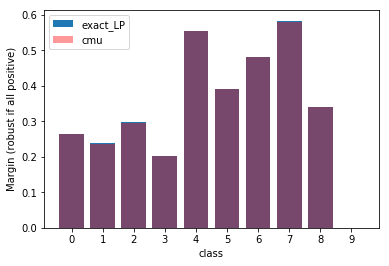

In [40]:
# np.array(margins) >= np.array(margins_cmu)
plt.bar([i for i in range(10)], margins, label='exact_LP')
plt.bar([i for i in range(10)], margins_cmu, color='r', alpha=0.4, label='cmu')
plt.legend()
plt.ylabel('Margin (robust if all positive)')
plt.xlabel('class')
plt.xticks([i for i in range(10)])
if np.all(np.array(margins)>=0):
    print('ROBUST for epsilon={}!'.format(epsilon))
else:
    print('NOT ROBUST for epsilon={} :('.format(epsilon))    

## Relu stability constraint elimination 2


In [41]:
C = np.eye(num_classes)[y_pred] - np.eye(num_classes)

affine, biases = init_affine(net, X)
num_linear_layers = len(affine)

W = [l(Variable(torch.eye(l.in_features))).t().cpu().data.numpy() for l in affine]
b = [bias.view(-1).cpu().data.numpy() for bias in biases]

points_all_samples = []
zl = [[] for i in range(num_linear_layers)]
zu = [[] for i in range(num_linear_layers)]
I_minus = [[] for i in range(num_linear_layers)]
I_plus = [[] for i in range(num_linear_layers)]
I = [[] for i in range(num_linear_layers)]

margins = []

end_time = time.time()
for k in range(num_linear_layers):
    print('Layer: ',k)
    print('Number of nodes in the layer: ',affine[k].out_features)
    if k == num_linear_layers -1:
        z = [cp.Variable(l.in_features) for l in affine[:k+1]]
        zhat = [cp.Variable(l.out_features) for l in affine[:k+1]]
        cons_ball = [z[0] >= sample - epsilon, z[0] <= sample + epsilon]
        cons_eq = [zhat[i] == W[i]*z[i] + b[i] for i in range(k+1)]

        cons_minus = [z[i][I_minus[i-1]] == 0 for i in range(1,k+1) if np.sum(I_minus[i-1]) != 0]
        cons_plus = [z[i+1][I_plus[i]] == zhat[i][I_plus[i]] for i in range(k) if np.sum(I_plus[i]) != 0]

        cons_zero = [z[i][I[i-1]] >= 0 for i in range(1,k+1) if np.sum(I[i-1]) != 0]
        cons_linear = [z[i+1][I[i]] >= zhat[i][I[i]] for i in range(k) if np.sum(I[i]) != 0]
        cons_upper = [(cp.multiply(-zu[i][I[i]], zhat[i][I[i]]) + 
                       cp.multiply((zu[i][I[i]] - zl[i][I[i]]), z[i+1][I[i]]) <= 
                         - zl[i][I[i]]*zu[i][I[i]]) for i in range(k) if np.sum(I[i]) != 0]
        cons = cons_eq + cons_ball + cons_zero + cons_linear + cons_upper + cons_minus + cons_plus

        for node_idx in range(affine[k].out_features):
            if node_idx == y_pred.item():
                margins.append(0)
                continue
            f_primal_1 = cp.Problem(cp.Minimize(C[node_idx]*zhat[-1]), cons).solve(verbose=False, solver=cp.ECOS, warm_start=True)
            margins.append(f_primal_1)
        iter_time = time.time()
        print("Time for solving this layer: {0} sec".format(iter_time-end_time))
        end_time = iter_time
        print('\n')

        break    

    z = [cp.Variable(l.in_features) for l in affine[:k+1]]
    zhat = [cp.Variable(l.out_features) for l in affine[:k]]
    zhat += [cp.Variable(1)]
    cons_ball = [z[0] >= sample - epsilon, z[0] <= sample + epsilon]

    cons_minus = [z[i][I_minus[i-1]] == 0 for i in range(1,k+1) if np.sum(I_minus[i-1]) != 0]
    cons_plus = [z[i+1][I_plus[i]] == zhat[i][I_plus[i]] for i in range(k) if np.sum(I_plus[i]) != 0]
    
    cons_zero = [z[i][I[i-1]] >= 0 for i in range(1,k+1) if np.sum(I[i-1]) != 0]
    cons_linear = [z[i+1][I[i]] >= zhat[i][I[i]] for i in range(k) if np.sum(I[i]) != 0]
    cons_upper = [(cp.multiply(-zu[i][I[i]], zhat[i][I[i]]) + 
                   cp.multiply((zu[i][I[i]] - zl[i][I[i]]), z[i+1][I[i]]) <= 
                     - zl[i][I[i]]*zu[i][I[i]]) for i in range(k) if np.sum(I[i]) != 0]
    
    for node_idx in range(affine[k].out_features):
        cons_eq = [zhat[i] == W[i]*z[i] + b[i] for i in range(k)]
        cons_eq += [zhat[k] == W[k][node_idx]*z[k] + b[k][node_idx]]

        cons = cons_eq + cons_ball + cons_zero + cons_linear + cons_upper + cons_minus + cons_plus

        if k == num_linear_layers-1:
            if node_idx == y_pred.item():
                margins.append(0)
                continue
            f_primal_1 = cp.Problem(cp.Minimize(C[node_idx]*zhat[-1]), cons).solve(verbose=False, solver=cp.ECOS, warm_start=True)
            margins.append(f_primal_1)
        else:
            # Exact
            f_primal_1 = cp.Problem(cp.Minimize(zhat[-1]), cons).solve(verbose=False, solver=cp.ECOS, warm_start=True)
            f_min = zhat[-1][0].value
            zl[k].append(f_min)

            f_primal_2 = cp.Problem(cp.Maximize(zhat[-1]), cons).solve(verbose=False, solver=cp.ECOS, warm_start=True)
            f_max = zhat[-1][0].value
            zu[k].append(f_max)

    zl[k] = np.array(zl[k])
    zu[k] = np.array(zu[k])
    I_minus[k] = zu[k] < 0
    I_plus[k] = zl[k] > 0
    I[k] = (zu[k] >= 0) * (zl[k] <= 0)
    print('Percentage of Stable ReLUs = {} %'.format(100 - 100*np.sum(I[k])/len(I[k])))
    iter_time = time.time()
    print("Time for solving this layer: {0} sec".format(iter_time-end_time))
    end_time = iter_time
    print('\n')


Layer:  0
Number of nodes in the layer:  10
Percentage of Stable ReLUs = 40.0 %
Time for solving this layer: 0.18602657318115234 sec


Layer:  1
Number of nodes in the layer:  10
Percentage of Stable ReLUs = 80.0 %
Time for solving this layer: 0.6167488098144531 sec


Layer:  2
Number of nodes in the layer:  10
Time for solving this layer: 0.363037109375 sec




ROBUST for epsilon=0.01!


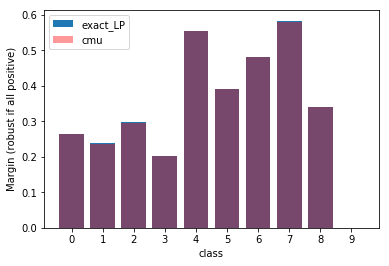

In [42]:
# np.array(margins) >= np.array(margins_cmu)
plt.bar([i for i in range(10)], margins, label='exact_LP')
plt.bar([i for i in range(10)], margins_cmu, color='r', alpha=0.4, label='cmu')
plt.legend()
plt.ylabel('Margin (robust if all positive)')
plt.xlabel('class')
plt.xticks([i for i in range(10)])
if np.all(np.array(margins)>=0):
    print('ROBUST for epsilon={}!'.format(epsilon))
else:
    print('NOT ROBUST for epsilon={} :('.format(epsilon))    